# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the A ansatz

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ, QuantumRegister, ClassicalRegister

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

from qiskit.circuit import Parameter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [66]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [67]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [68]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [69]:
def initial_state_preparation(mapper_str: str = "pa"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [70]:
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation("jw")

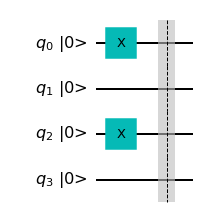

In [71]:
init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
init_state.barrier()

init_state.draw("mpl", initial_state=True)

In [72]:
theta = Parameter("t")
phi = Parameter("p")

R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
R.ry(theta + (0.5 * np.pi), 0)
R.rz(phi + np.pi, 0)

Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
Rd.ry(theta + (0.5 * np.pi), 0).inverse()
Rd.rz(phi + np.pi, 0).inverse()

a_var_form = QuantumCircuit(2)#qubit_op.num_qubits)
a_var_form.cx(1, 0)
a_var_form.append(Rd, [1])
a_var_form.cx(0, 1)
a_var_form.append(R, [1])
a_var_form.cx(1, 0)

ansatz = TwoLocal(
    num_qubits = qubit_op.num_qubits,
    rotation_blocks = [ a_var_form ],
    entanglement_blocks = [ a_var_form ],
    entanglement = [[1, 2]],
    reps=2,
    skip_unentangled_qubits = False,
    skip_final_rotation_layer = True,
    # parameter_prefix = theta,
    insert_barriers = True,
    # initial_state = init_state,
    name = "$A(\\theta, \phi)$"
)

ansatz.compose(init_state, front=True, inplace=True)


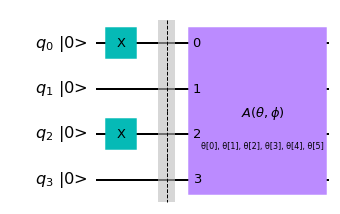

In [73]:
ansatz.draw(output="mpl", initial_state=True).savefig("a_vqe_h2_ansatz.png", dpi=300)

ansatz.draw(output="mpl", initial_state=True)

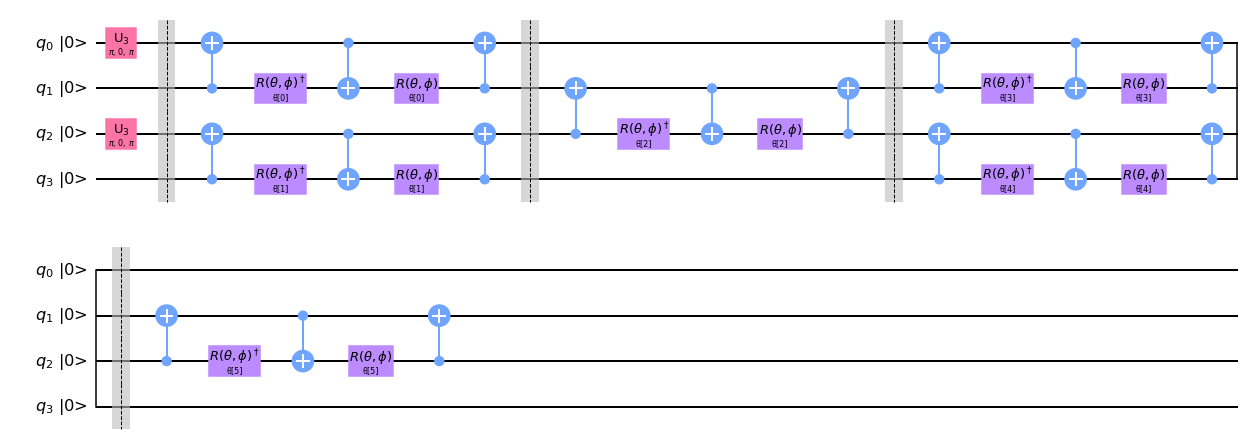

In [74]:
ansatz.decompose().draw(output="mpl", initial_state=True).savefig("a_vqe_h2_ansatz_decomposed.png", dpi=300)

ansatz.decompose().draw(output="mpl", initial_state=True)

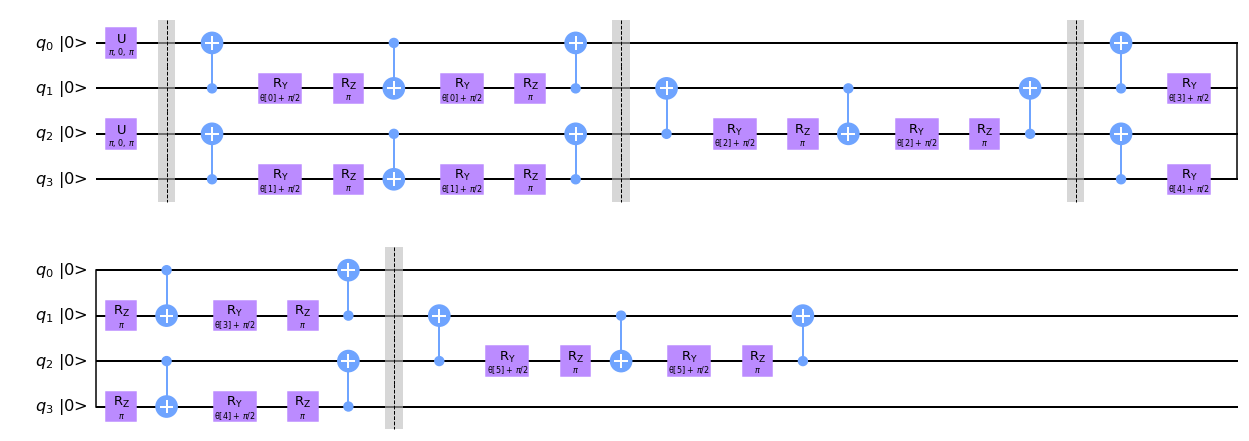

In [75]:
ansatz.decompose().decompose().draw(output="mpl", initial_state=True).savefig("a_vqe_h2_ansatz_double_decomposed.png", dpi=300)

ansatz.decompose().decompose().draw(output="mpl", initial_state=True)

In [76]:
optimizer = COBYLA(maxiter=10000)

### Solver

Exact Eigensolver using NumPyMinimumEigensolver


In [77]:
result_exact = exact_diagonalizer(es_problem, qubit_converter)
exact_energy = np.real(result_exact.eigenenergies[0])

print("Exact Electronic Energy: {:.4f} Eh\n\n".format(exact_energy))

print("Results:\n\n", result_exact)

Exact Electronic Energy: -1.8573 Eh


Results:

 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


### VQE Solver

In [78]:
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# we choose a fixed small displacement

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
algorithm = VQE(
    ansatz,
    optimizer=optimizer,
    quantum_instance=state_sim,
    callback=callback,
    initial_point=initial_point
)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 638,
    'eigenstate': array([-5.74382545e-18-1.28021094e-17j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -1.81637334e-04-2.51443271e-18j,
        0.00000000e+00+0.00000000e+00j,  9.93759284e-01+6.14131976e-16j,
        8.72258167e-05+1.83594304e-17j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -1.21220725e-04-4.04387267e-18j,
       -1.11539088e-01-9.57821475e-17j,  0.00000000e+00+0.00000000e+00j,
        1.20914724e-03+4.36098693e-18j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  5.25528188e-18+1.60059337e-17j]),
    'eigenvalue': (-1.8572741003211513+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[2]): 0.02630317245329703,
                              ParameterVectorElement(θ[4]): -0.22401273614960937,
                              ParameterVectorElement(θ[3]): 0.21602970966315688,
                              Paramete

In [79]:
# print(values)

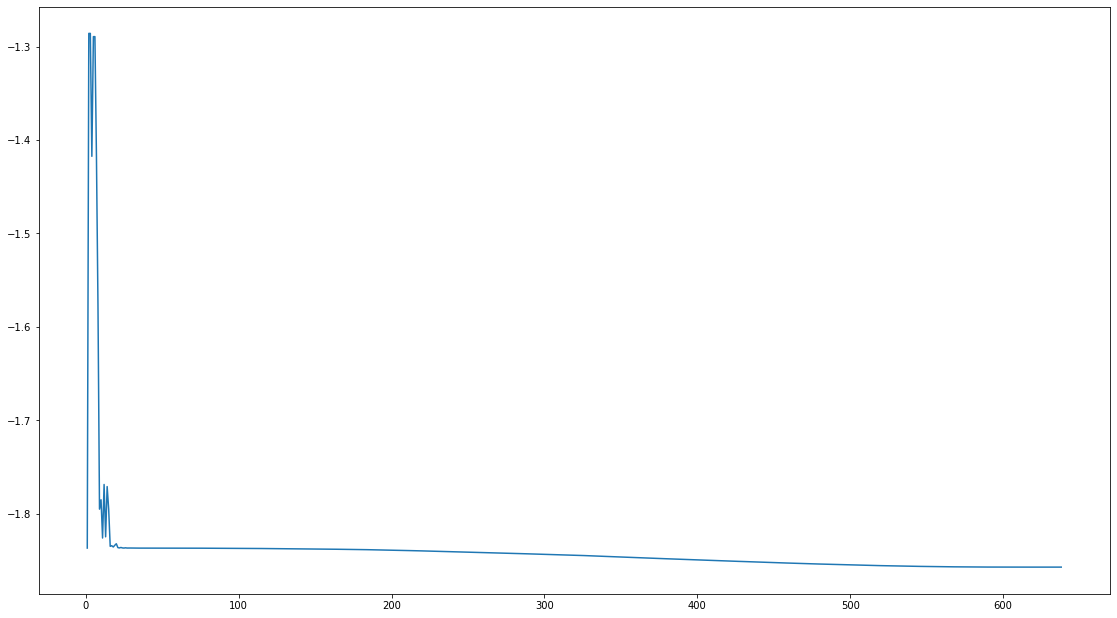

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.plot(counts, values)
plt.show()

In [81]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': qubit_converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    # 'rotation blocks': rotation_blocks,
    # 'entanglement_blocks': entanglement_blocks,
    # 'entanglement': entanglement,
    # 'repetitions': repetitions,
    # 'skip_final_rotation_layer': skip_final_rotation_layer,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

,optimizer,ansatz,# of qubits,error (mHa),pass,score,# of parameters,# of CNOTs
0,COBYLA,TwoLocal,4,0.00093,True,18,6,18


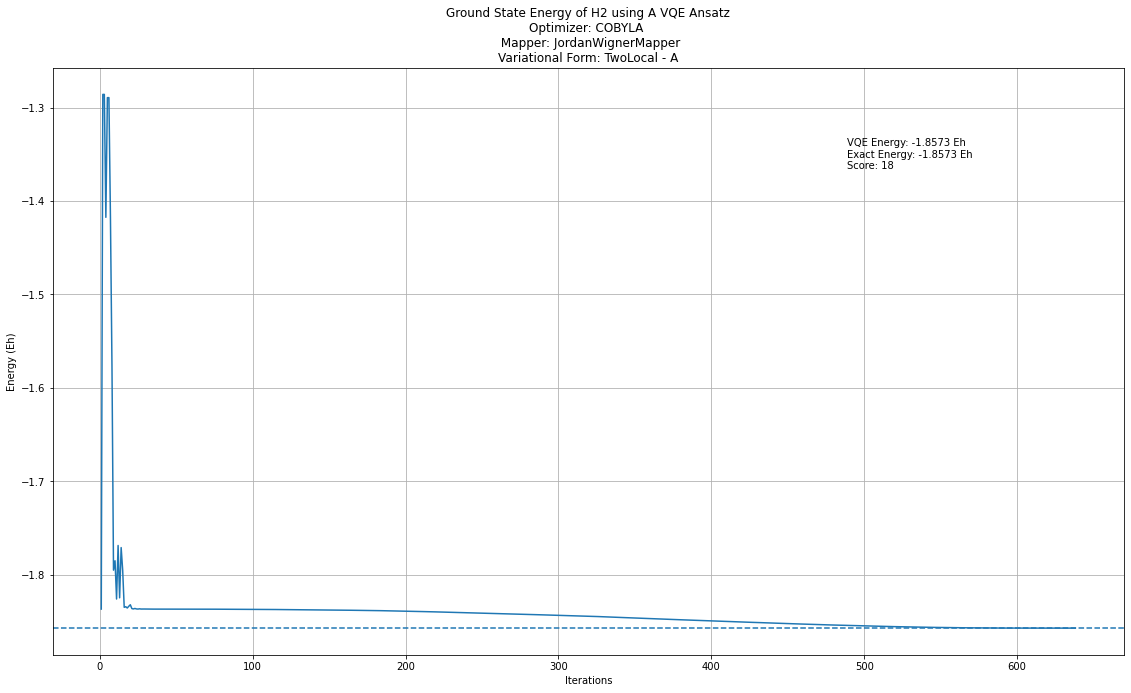

In [83]:
# Plotting the results


fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

# ax.set_facecolor("#293952")
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Eh)')
ax.grid()

fig.text(0.7, 0.75, f'VQE Energy: {result.optimal_value:.4f} Eh\nExact Energy: {exact_energy:.4f} Eh\nScore: {score:.0f}')

plt.title(f"Ground State Energy of H2 using A VQE Ansatz\nOptimizer: {result_dict['optimizer']} \n Mapper: {result_dict['mapping']}\nVariational Form: {result_dict['ansatz']} - A")

ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')

fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
# fig.savefig(fig_title, dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', 'error (mHa)', 'pass', 'score','# of parameters', "# of CNOTs"]]
